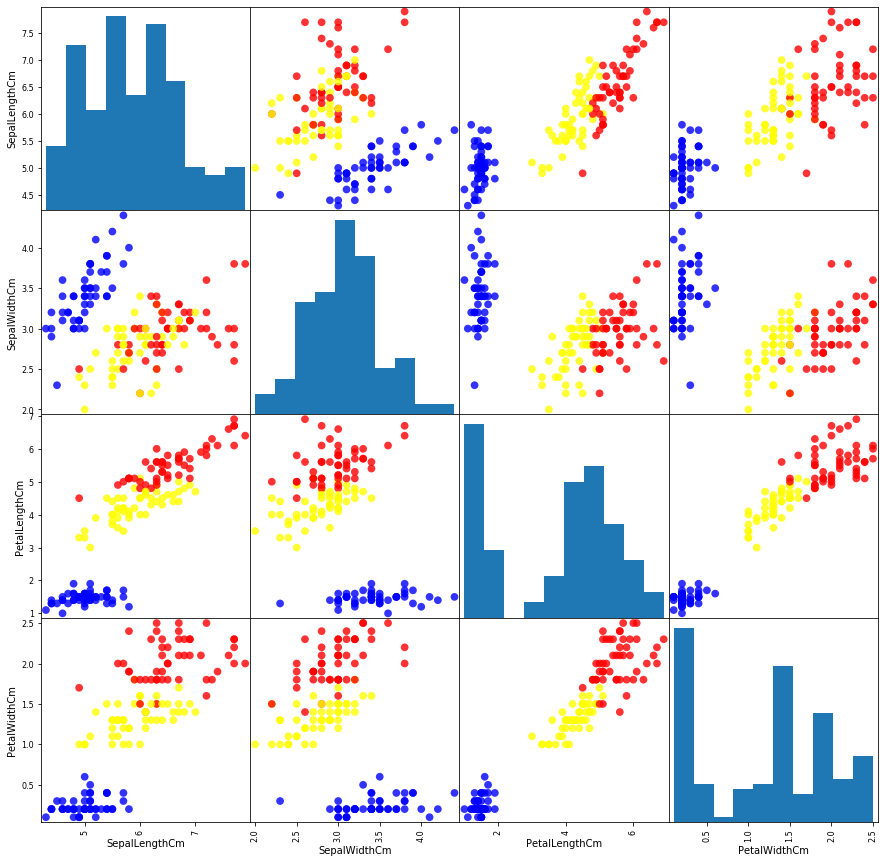

In [1]:
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
iris_data = pd.read_csv('iris.csv')

iris_data = iris_data.reindex(np.random.permutation(iris_data.index))
    
def assign_colors_to_iris(y_train):
    colors = []
    for row in y_train:
        assigned = "blue"
        if (row == "Iris-versicolor"):
            assigned = "yellow"
        elif(row == "Iris-virginica"):
            assigned = "red"
        colors.append(assigned)
    return colors
pd.plotting.scatter_matrix(iris_data[["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]], marker='o', s=60, alpha=0.8, figsize=(15, 15), color=assign_colors_to_iris(iris_data['Species']))
plt.show()

## Analyze the Data

In [2]:
iris_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 72 to 113
Data columns (total 6 columns):
Id               150 non-null int64
SepalLengthCm    150 non-null float64
SepalWidthCm     150 non-null float64
PetalLengthCm    150 non-null float64
PetalWidthCm     150 non-null float64
Species          150 non-null object
dtypes: float64(4), int64(1), object(1)
memory usage: 8.2+ KB


In [3]:
iris_data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
72,73,6.3,2.5,4.9,1.5,Iris-versicolor
31,32,5.4,3.4,1.5,0.4,Iris-setosa
48,49,5.3,3.7,1.5,0.2,Iris-setosa
102,103,7.1,3.0,5.9,2.1,Iris-virginica
117,118,7.7,3.8,6.7,2.2,Iris-virginica


## Training Data

In [4]:
x_train, y_train = iris_data.drop(['Species'], axis=1)[:110], iris_data['Species'][:110]
x_test, y_test = iris_data.drop(['Species'], axis=1)[110:], iris_data['Species'][110:]
x_train.drop(["Id"], inplace=True, axis=1)
x_train.reset_index(drop=True, inplace=True)

## Principal Component Analysis

In [5]:
from mpl_toolkits.mplot3d import Axes3D

class MyPCA:
    def __init__(self, n_components):
        self.n_components = n_components
    
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)
    
    def fit(self, data):
        self.dim_mean_list = self.mean_per_dimension(data)
    
    def transform(self, data):
        self.centered_data = self.center_columns(data, self.dim_mean_list)
        cov_matrix, cov_matrix_df = self.covariance(data, self.dim_mean_list)
        eigenvector_list = self.eigenvector(cov_matrix, data.columns)[0:self.n_components]
        self.eigenvectors = [eigen[2] for eigen in eigenvector_list]
        self.pca_data = pd.DataFrame(np.dot(self.centered_data, np.transpose(self.eigenvectors)), columns=["Principal Component " + str(i) for i in range(1, self.n_components+1)])
        return self.pca_data
    
    def mean_per_dimension(self, data):
        dim_mean_list = {}
        for column_name, column_data in data.iteritems():
            dim_mean_list[column_name] = np.mean(column_data)
        return dim_mean_list
        
    def covariance(self, data, dim_mean_list):
        num_features = data.shape[1]
        n_samples = data.shape[0]
        cov_matrix = [[0 for i in range(num_features)] for j in range(num_features)]
        col_index = 0
        for col_1 in data.columns:
            row_index = 0
            for col_2 in data.columns:
                cov_matrix[row_index][col_index] = 1/(n_samples-1)*np.sum((data[col_1]-dim_mean_list[col_1])*(data[col_2]-dim_mean_list[col_2]))
                row_index+=1
            col_index += 1
        cov_matrix_df =  pd.DataFrame(cov_matrix, columns=data.columns)
        cov_matrix_df.index = data.columns
        return cov_matrix, cov_matrix_df
    
    def eigenvector(self, cov_matrix, columns):
        eigenvalues, eigenvector = np.linalg.eig(cov_matrix)
        eigenvector_t = np.transpose(eigenvector)
        eigen_tuple = [(columns[i], eigenvalues[i], eigenvector_t[i]) for i in range(len(eigenvalues))]
        #sort by eigenvalue
        return sorted(eigen_tuple, key = lambda x: x[1], reverse=True)   
    
    def center_columns(self, data, mean_per_column):
        centered_df = data.copy()
        for column_name in mean_per_column:
            centered_df[column_name] = centered_df[column_name].apply(self.substract_values, value=mean_per_column[column_name])
        return centered_df.values
        
    def substract_values(self, col, value):
        return col-value
    
    def labelsToInt(self, labels):
        colors = ['r']
        n_labels = len(labels)
        id_result = [0 for i in range(n_labels)]
        id_dict = {}
        id_count = 0
        for i in range(n_labels):
            if labels[i] not in id_dict:
                id_dict[labels[i]] = id_count
                id_count+=1
            id_result[i] = id_dict[labels[i]]
        return id_result
    
    def plot(self, title, results):
        res_color = self.labelsToInt(results)
        fig=plt.figure()
        if (self.n_components == 2):
            ax=fig.add_axes([0,0,1,1])
            ax.scatter(self.pca_data[self.pca_data.columns[0]], self.pca_data[self.pca_data.columns[1]], c=res_color)
            ax.set_xlabel("Principal Component 1")
            ax.set_ylabel("Principal Component 2")
        elif (self.n_components == 3):
            ax = Axes3D(fig)
            ax.scatter(self.pca_data[self.pca_data.columns[0]], self.pca_data[self.pca_data.columns[1]], self.pca_data[self.pca_data.columns[2]],  c=res_color)
            ax.set_xlabel("Principal Component 1")
            ax.set_ylabel("Principal Component 2")
            ax.set_zlabel("Principal Component 3")
        ax.set_title(title)
        plt.show()

## PCA with dimension 2

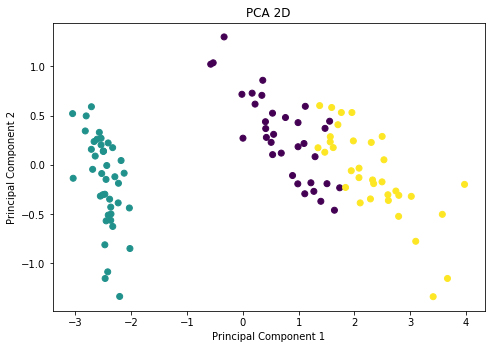

In [6]:
my_pca = MyPCA(2)
my_pca.fit(x_train)
pca_train_data = my_pca.transform(x_train)
my_pca.plot("PCA 2D", y_train.values)

## Compare with SK Learn Algorithm

In [7]:
pca_train_data

,Principal Component 1,Principal Component 2
0,1.474190,0.371801
1,-2.230550,-0.384737
2,-2.363925,-0.561795
3,2.795306,-0.308155
4,3.667021,-1.151932
...,...,...
105,3.972573,-0.196938
106,0.411563,0.369648
107,-2.469198,-0.810138
108,1.568234,0.287476


SKLearn result

In [8]:
from sklearn.decomposition import PCA 
  
pca = PCA(n_components = 2) 
  
pca_sklearn = pca.fit_transform(x_train)
pca_sklearn

array([[ 1.47419033, -0.37180086],
       [-2.23055049,  0.38473678],
       [-2.36392534,  0.56179471],
       [ 2.79530635,  0.30815485],
       [ 3.66702061,  1.15193246],
       [ 2.49478247,  0.17130946],
       [ 1.76619177, -0.53272186],
       [-0.52903556, -1.03735231],
       [ 1.73609658,  0.23151839],
       [ 1.09738008, -0.21811408],
       [ 0.35914546, -0.85981718],
       [ 0.76552106, -0.48185971],
       [ 1.46970423, -0.12951047],
       [-0.57343222, -1.02313464],
       [ 0.22090243, -0.61799393],
       [ 2.34482372,  0.18914256],
       [-2.28989561,  0.11934907],
       [-2.54981013,  0.31588553],
       [-2.46911771,  0.29660031],
       [ 1.84165866,  0.22790296],
       [ 2.32538915,  0.15182757],
       [ 0.53351174, -0.5259682 ],
       [-2.68797309,  0.04417145],
       [-3.04677357, -0.52156235],
       [-2.70967667, -0.59139188],
       [-2.41031373, -0.22384334],
       [-2.46389324,  1.15207124],
       [ 1.27400302,  0.26764837],
       [ 1.22103094,

## PCA with dimension 3

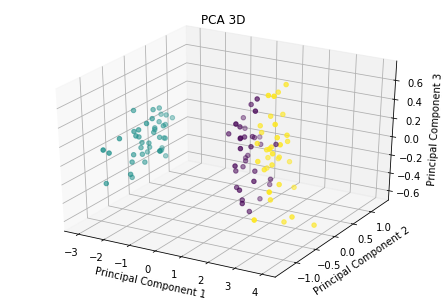

In [9]:
my_pca3 = MyPCA(3)
pca_data3 = my_pca3.fit_transform(x_train)
my_pca3.plot("PCA 3D", y_train.values)

## Test Results

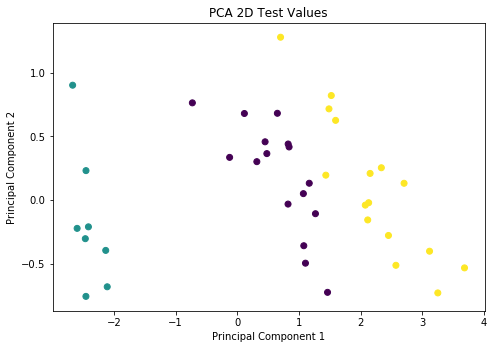

In [10]:
x_test.drop(["Id"], inplace=True, axis=1)
x_test.reset_index(drop=True, inplace=True)
pca_test_data = my_pca.transform(x_test)
my_pca.plot("PCA 2D Test Values", y_test.values)

## Implement K-Nearest Neighbors

In [11]:
#My own K means clustering algorithm
import random
from math import sqrt

def euclidean_distance(object1, object2):
    distance = 0.0
    for i in range(len(object1)-1):
        distance += (object1[i] - object2[i])**2
    return sqrt(distance)

def get_neighbors(train_data, test_row, k):
    distances = []
    for row in train_data.iterrows():
        train_object = row[1]
        distance = euclidean_distance(test_row, train_object)
        distances.append((distance, train_object))
    distances.sort(key=lambda tup: tup[0])
    neighbors = list()
    for i in range(k):
        neighbors.append(distances[i][1])
    return neighbors

cluster_belongings = get_neighbors(x_train, x_test.iloc[0, :], 3)